<a href="https://colab.research.google.com/github/TacticalNuclearRaccoon/Artificial-Neural-Networks/blob/main/Fundamentals_of_Medical_Image_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fundamentals of Medical Image Processing

In [27]:
!pip install pydicom

In [28]:
#!pip installation of gdcm (although the install is successful) gives an error at the import.
#therefore I am installing conda in order to !conda install gdcm
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [29]:
!conda install -c conda-forge gdcm -y

Solving environment: - \ | / - \ | / - \ | / - done

# All requested packages already installed.



In [30]:
# Loading packages & libraies

import numpy as np 
import pandas as pd 
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import KMeans
import shutil
import cv2
import pydicom
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns
from IPython.display import HTML
import gdcm
from subprocess import check_output

import os

In [31]:
# Loading datasets into colab directly from Kaggle
from google.colab import files
kaggle_token = files.upload()

Saving kaggle.json to kaggle (1).json


In [32]:
# install Kaggle library
!pip install kaggle

In [33]:
# make new directory called kaggle
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [34]:
#copy the kaggle token inside this directory
!cp kaggle.json ~/.kaggle/

In [35]:
# allocate user read-write access to the token
!chmod 600 ~/.kaggle/kaggle.json

In [36]:
#download the data from the competition
#API commands can be found on the dataset page of the competition
!kaggle competitions download -c osic-pulmonary-fibrosis-progression

osic-pulmonary-fibrosis-progression.zip: Skipping, found more recently modified local copy (use --force to force download)


In [37]:
#unzipping the .zip file
!unzip osic-pulmonary-fibrosis-progression.zip

Archive:  osic-pulmonary-fibrosis-progression.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/ID00419637202311204720264/1.dcm? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/ID00419637202311204720264/10.dcm? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/ID00419637202311204720264/11.dcm? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/ID00419637202311204720264/12.dcm? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/ID00419637202311204720264/13.dcm? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/ID00419637202311204720264/14.dcm? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/ID00419637202311204720264/15.dcm? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/ID00419637202311204720264/16.dcm? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/ID00419637202311204720264/17.dcm? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/ID00419637202311204720264/

In [45]:
def set_options():
  '''setting display options for pandas. Maximum number of columns, wcolumn width and max number of rows.'''
  pd.set_option('display.max_columns', 100)
  pd.set_option('display.max_colwidth', None)
  pd.set_option('display.max_rows', 1000)

In [46]:
set_options()

In [47]:
# Load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [48]:
# set iamge paths as variables
TRAIN_IMG_PATH = 'train'
TEST_IMG_PATH = 'test'

In [49]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


## Tha Anatomical Coordinate System

The anatomical coordinate system has 3 planes:

* **Axial (transverse) plane** - The axial plane is actually when you place point of view above the patient and look down. Depending on the region of the 3D medical image you will observe different anatomical structures. For a 3D total body scan, if you had a control-bar over this 2D view you would start from a 2D slice of the head, and by increasing you would end up in the legs. Let’s practically call this view the “drone plane” or “top-view”. Slices near to head is known as superior and towards feet is known as inferior. Below is axial plane of lungs CT Scans.

* **Sagittal plane** - Basically, this is a side view. Instead of looking from above the patient, now we look from the side. The side can be either right or left. Which side and direction is the positive one, depends on the coordinate system.

* **Coronal plane** – In this point of view is either in front of eyes(anterior plane) or back of the patient(posterior plane)

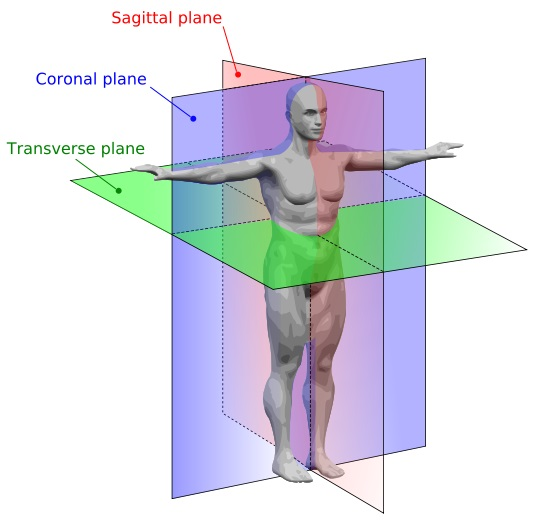

## About data
Medical dataset containing lungs CT scans of patients diagnosed with pulmonary fibrosis a disorder with no known cause and no known cure, created by scarring of the lungs. Prognosis of the troubling disease becomes frightening for the patients because outcomes can range from long-term stability to rapid deterioration, but doctors aren’t easily able to tell where an individual may fall on that spectrum. This is where data science can help in predicting the detoriating condition of the patients. 

## What is DICOM?
A DICOM image file is an outcome of the Digital Imaging and Communications in Medicine standard and represented as .dcm. Because of its ease of integration and continuous evolution this communication standard has over the years achieved a nearly universal level of acceptance among vendors of radiological equipment.DICOM differs from other image formats because it groups information into datasets. DICOM file consist of header and image data collectively in one file. We will see later how these group of information looks like and interpreted. For more information you can refer to [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3354356/).

In [50]:
def load_slices(path):
  '''This function sorts images according to InstanceNumber'''
  filenames = os.listdir(path)
  slices = [pydicom.dcmread(f'{path}/{file}') for file in filenames]
  slices.sort(key = lambda x: int(x.InstanceNumber), reverse=True)
  return slices

In [51]:
scans = load_slices(f'{TRAIN_IMG_PATH}/ID00007637202177411956430')
scans[0]
# there is a lot of metadata!

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.95516132172461492040664114239048418896
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.95516132172461492040664114239048418896
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) 

## Conversion to Hounsfield Units
The Hounsfield scale is a quantitative scale for describing radiodensity in medical CT scan and provides an accurate density for the type of tissue. Plain x-rays which only displays 5 densities (i.e. air/fat/soft tissue/bone/metal), CT displays a huge range of densities ranging from air (black) to bone (white). On the Hounsfield scale, water represented by 0 value, air is represented by a value of −1000 (black on the grey scale) and bone between +700 (cancellous bone) to +3000 (dense bone) (white on the grey scale). As bones are much denser than surrounding soft tissues, they show up very clearly in CT images. Raw pixel values of images gets convereted into Hounsfield Units because the spectral composition of the x-rays depends on the measurement settings like acquisition parameters and tube voltage. By normalizing to values of water and air (water has HU 0 and air -1000) the images of different measurements are becoming comparable. Read more about Hounsfield units on [this article](https://www.sciencedirect.com/topics/medicine-and-dentistry/hounsfield-scale)

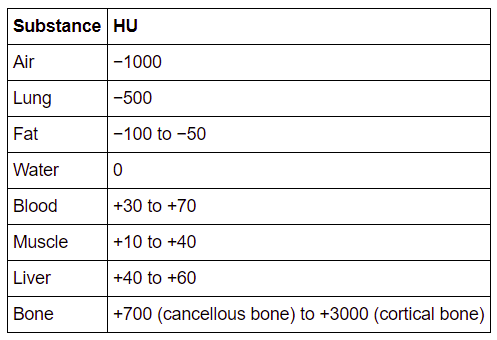

Rescale intercept, (0028|1052), and rescale slope (0028|1053) are DICOM tags that specify the linear transformation from pixels in their stored on disk representation to their in memory representation.
Whenever the values stored in each voxel have to be scaled to different units, Dicom makes use of a scale factor using two fields into the header defining the slope and the intercept of the linear transformation to be used to convert pixel values to real world values.

In [52]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image <= -1000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

# Windowing
Windowing is the process in which the grayscale of a particular image can be adjusted. Windowing uses two values window width and window level for getting a right/interested window. The window width is the range of the grayscale that can be displayed. The center of grayscale range is referred to as the window level.Window width controls contrast and window level controls brightness. That is why windowing also known as grey-level mapping, contrast stretching, histogram modification or contrast enhancement. A large window width means there is a long grayscale and the transition black to white will take longer and vice versa for smaller window width. An example to better explain: WW of 100 HU could mean the grayscale only ranges from 0HU to +100 HU, with a WL of +50 HU. For Lungs window width is 1500 and window level is -600, so grayscale ranges from 150HU to -1350HU. More about windowing can be read [here](https://radiopaedia.org/articles/windowing-ct?lang=us). How to get window width and level is explained briefly in [this article](https://www.researchgate.net/publication/272179277_Determining_effective_window_width_and_center_using_different_windowing_techniques_for_radio_therapy_images).

In [54]:
def apply_window(hu_image, center, width):
  '''This function applies Windowing to the image. Makes a copy of the image, defines a min, max value in grayscale'''
  hu_image = hu_image.copy()
  min_value = center - width // 2
  max_value = center + width // 2
  hu_image[hu_image < min_value] = min_value
  hu_image[hu_image > max_value] = max_value
  return hu_image

## Histogram Analysis
We plot a histogram for image pixels after converting to HU and raw pixel values. After converting to HU we can see there is lot of air(-1000) in the scan. Some fat and muscle is also seen.

In [55]:
train.loc[0]['Patient']

'ID00007637202177411956430'

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'HU unit distributions for 10 examples')

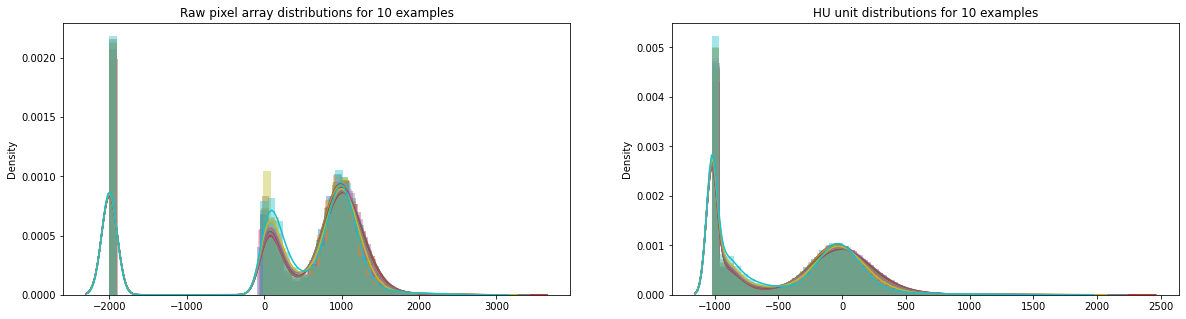

In [56]:
# plotting a histogram for image pixels for 10 examples
# TO DO: makes this a function which takes the number of examples to plot as argument
fig,ax = plt.subplots(1,2,figsize=(20,5))
example = train.loc[0]['Patient']
scans = load_slices(f'{TRAIN_IMG_PATH}/{example}')
rescaled_images=get_pixels_hu(scans)
images = [scan.pixel_array for scan in scans]
for i in range(10):
    sns.distplot(images[i].flatten(), ax=ax[0])
    sns.distplot(rescaled_images[i].flatten(), ax=ax[1])
ax[0].set_title("Raw pixel array distributions for 10 examples")
ax[1].set_title("HU unit distributions for 10 examples")

# Storing image in dataframe


In [58]:
def get_dicom_raw(dicom):
  '''extracts raw data frop DICOM image and stores in a dataframe
  takes DICOM image as argument and assumes that the metadata starts with uppercase character
  and excludes Pixel Data'''
  return ({attr:getattr(dicom, attr) for attr in dir(dicom) if attr[0].isupper() and attr not in ['PixelData']})

In [60]:
def get_dicom_metadata(df):
  '''extracts dicom metadata with featues like lung volume that are important metrics (according to specialists)
  returns it as a dataframe'''
  patients = df.Patient.unique()
  dicom_metadata = []
  for patient in patients:
      path = f'{TRAIN_IMG_PATH}/{patient}'
      img_list = os.listdir(path)
      for img in img_list:
          image = pydicom.dcmread(f'{path}/{img}')
          record = get_dicom_raw(image)
          raw = image.pixel_array
          pixelspacing_r, pixelspacing_c = image.PixelSpacing[0], image.PixelSpacing[1]
          row_distance = pixelspacing_r * image.Rows
          col_distance = pixelspacing_c * image.Columns
          record.update({'raw_min':raw.min(),
                      'raw_max':raw.max(),
                      'raw_mean':raw.mean(),
                      'raw_std':raw.std(),
                      'raw_diff':raw.max()-raw.min(),
                      'pixel_spacing_area':pixelspacing_r * pixelspacing_c,
                      'img_area':image.Rows * image.Columns,
                      'pixel_row_distance':row_distance,
                      'pixel_col_distance':col_distance,
                      'slice_area_cm2':(0.1 * row_distance) * (0.1 * col_distance),
                      'slice_vol_cm3':(0.1 * image.SliceThickness) * (0.1 * row_distance) * (0.1 * col_distance),
                      'patient_img_path':f'{path}/{img}'})

          dicom_metadata.append(record)
            
  metadata_df = pd.DataFrame(dicom_metadata)
  metadata_df.to_pickle('metadata_df.pkl')
  return metadata_df

In [61]:
%%time
metadata_df = get_dicom_metadata(train.copy())
metadata_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in short_scalars


CPU times: user 4min 3s, sys: 25.8 s, total: 4min 29s
Wall time: 7min 31s


## Voxel Size and Volume 
Volume of scans vary highly. But this is not because lungs of images having more voxel volume are bigger than others.

Voxel is 3D pixel having pixel spacing shows distance travelled by a pixel in x and y coordinates and slice thickness as z coordinate. Voxel we can imagine like a cuboid. So if pixel spacing(size) is more than definitely volume of image will be more. Lets plot variance of area, volume and pixel spacing to have an idea about number of images having large volumes.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 0, 'Volume in $cm^{3}$')

<Figure size 432x288 with 0 Axes>

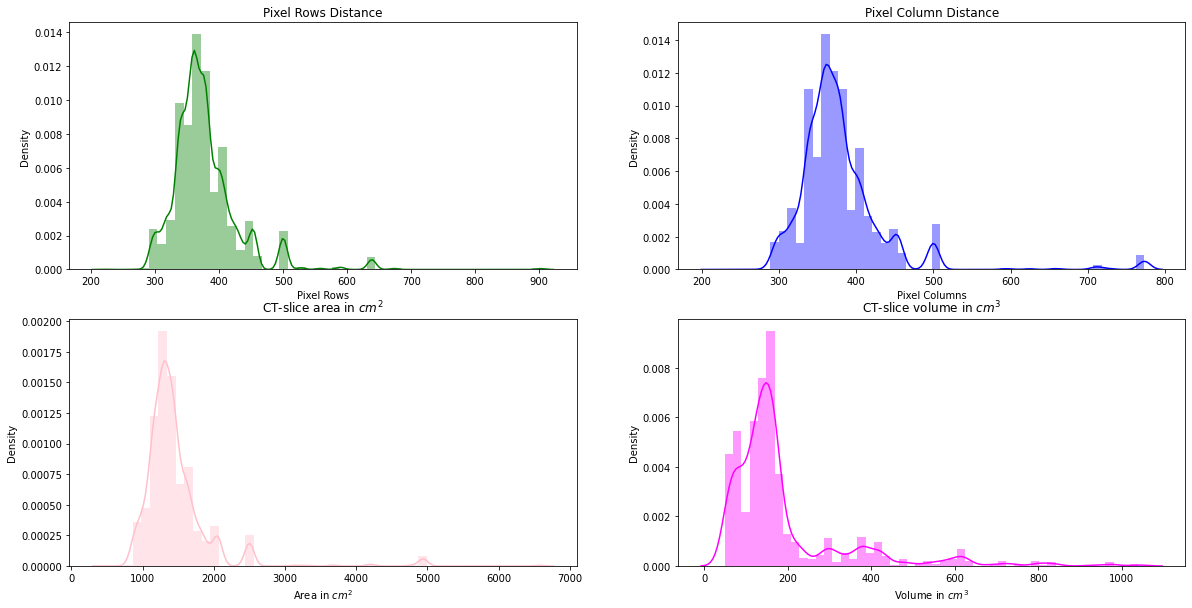

In [62]:
#plotting the metadta obtained
plt.tight_layout()
fig, ax = plt.subplots(2, 2, figsize=(20,10))
sns.distplot(metadata_df.pixel_row_distance, ax=ax[0,0], color='green')
sns.distplot(metadata_df.pixel_col_distance, ax=ax[0,1], color='blue')
sns.distplot(metadata_df.slice_area_cm2, ax=ax[1,0], color='pink')
sns.distplot(metadata_df.slice_vol_cm3, ax=ax[1,1], color='magenta')
ax[0,0].set_title("Pixel Rows Distance")
ax[0,0].set_xlabel("Pixel Rows")
ax[0,1].set_title("Pixel Column Distance")
ax[0,1].set_xlabel("Pixel Columns")
ax[1,0].set_title("CT-slice area in $cm^{2}$")
ax[1,0].set_xlabel("Area in $cm^{2}$")
ax[1,1].set_title("CT-slice volume in $cm^{3}$")
ax[1,1].set_xlabel("Volume in $cm^{3}$")

Area and volume of the lungs seem to vary a lot. Below a plot of highest and lowest volume patients:

Text(0.5, 1.0, 'CT with small volume')

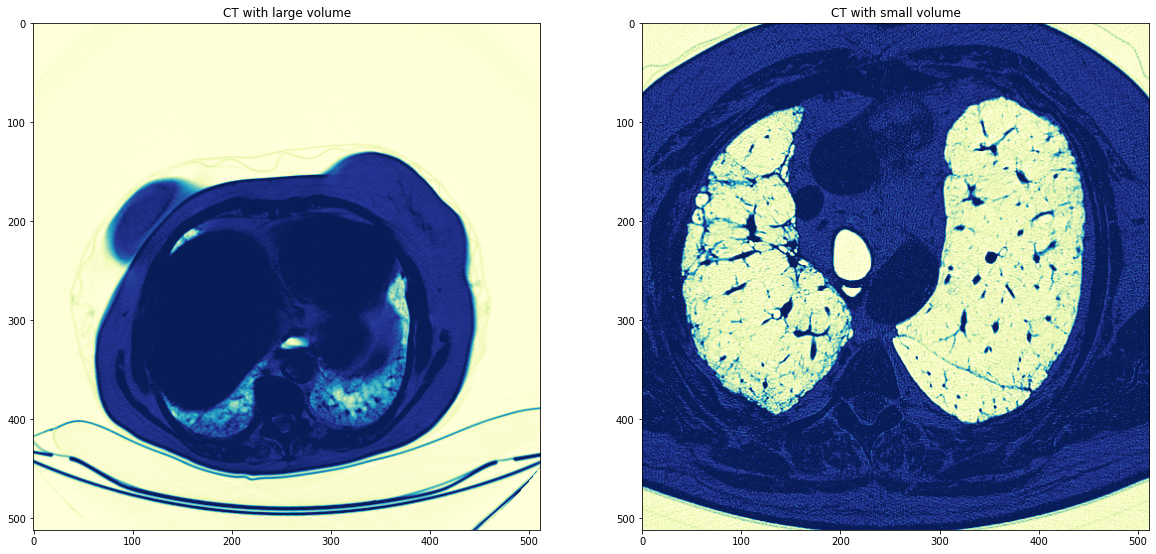

In [63]:
highest_vol_patients = list(metadata_df[metadata_df.slice_vol_cm3 == max(metadata_df.slice_vol_cm3)]['PatientID'])
lowest_vol_patients = list(metadata_df[metadata_df.slice_vol_cm3 == min(metadata_df.slice_vol_cm3)]['PatientID'])
# Load scans for highest and lowest volume lung patients
max_vol_scans = load_slices(f"{TRAIN_IMG_PATH}/{highest_vol_patients[0]}")
min_vol_scans = load_slices(f"{TRAIN_IMG_PATH}/{lowest_vol_patients[0]}")
# Convert to HU
max_vol_hu_imgs = get_pixels_hu(max_vol_scans)
min_vol_hu_imgs = get_pixels_hu(min_vol_scans)
# Apply windowing]
# We can try with different window width and levels.
max_vol_window_img = apply_window(max_vol_hu_imgs[20], -600, 1200)
min_vol_window_img = apply_window(min_vol_hu_imgs[18], -600, 1200)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(max_vol_window_img, cmap="YlGnBu")
ax[0].set_title("CT with large volume")
ax[1].imshow(min_vol_window_img, cmap="YlGnBu")
ax[1].set_title("CT with small volume")

## Resampling
Voxel size resampling is an appropriate preprocessing step for image data sets acquired with variable voxel sizes in order to obtain more reproducible CT features. Some of radiomics features are voxel size and gray level discretization dependent. The introduction of normalizing factors in their definitions greatly reduced or removed these dependencies. In computed tomography, voxel size in a region of interest depends on both pixel dimensions (x-y plane) and slice thickness (z-axis), assuming slice thickness equals interslice distance. Any change in these two parameters changes CT image resolution or voxel size. A minimally curation step may be to resample image sets so that all have the same voxel size. In this paper, voxel size resampling was investigated as a way to minimize the variability in feature values due to differing voxel sizes.

Voxel intensities within a region of interest (ROI) are typically resampled into a limited number of discrete values or bin sizes before calculating feature values. Different studies have used different gray level resampling before extracting texture features. Later normalization is also done to improve robustness of these features.

In [64]:
metadata_df.SliceThickness.unique()

array([1.25    , 2.      , 1.      , 7.      , 0.8     , 0.5     ,
       0.625   , 2.5     , 3.      , 0.9     , 5.      , 0.835938,
       0.75    , 1.5     , 8.      , 6.5     ])

In [65]:
# Lets see thickness for slices before thinking about resampling.
patient1 = train.Patient.unique()[0]
patient2 = train.Patient.unique()[5]
scans1 = load_slices(f"{TRAIN_IMG_PATH}/{patient1}")
scans2 = load_slices(f"{TRAIN_IMG_PATH}/{patient2}")
print(f"{scans1[0].SliceThickness}, {scans1[0].PixelSpacing}")
print(f"{scans2[0].SliceThickness}, {scans2[0].PixelSpacing}")

1.250000, [0.652344, 0.652344]
1.250000, [0.798828, 0.798828]


In [66]:
patient1_hu_scans = get_pixels_hu(scans1)
patient2_hu_scans = get_pixels_hu(scans2)

In [67]:
def resample(image, scan, new_spacing=[1,1,1]):
    '''This function determines current pixel spacing and attributes a new spacing of [1,1,1]'''
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    return image, new_spacing

In [68]:
image1, rounded_new_spacing1 = resample(patient1_hu_scans, scans1, [1,1,1])
image2, rounded_new_spacing2 = resample(patient2_hu_scans, scans2, [1,1,1])
print(f"Original shape : {patient2_hu_scans.shape}")
print(f"Shape after resampling : {image2.shape}")

Original shape : (31, 843, 888)
Shape after resampling : (39, 673, 709)


## 3D Plotting

In [69]:
def plot_3d(image,threshold=800):
  '''This function plots the 3D image. 
  It positions the the scan upright so that the head of the patient is at the top, facin the camera.
  Returns a plot on display.'''
  p = image.transpose(2,1,0)
    
  verts, faces, _, _ = measure.marching_cubes_lewiner(p, threshold)
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')
  # Fancy indexing: `verts[faces]` to generate a collection of    
  # triangles
  mesh = Poly3DCollection(verts[faces], alpha=0.70)
  face_color = [0.45, 0.45, 0.75]
  mesh.set_facecolor(face_color)
  ax.add_collection3d(mesh)
  ax.set_xlim(0, p.shape[0])
  ax.set_ylim(0, p.shape[1])
  ax.set_zlim(0, p.shape[2])
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  


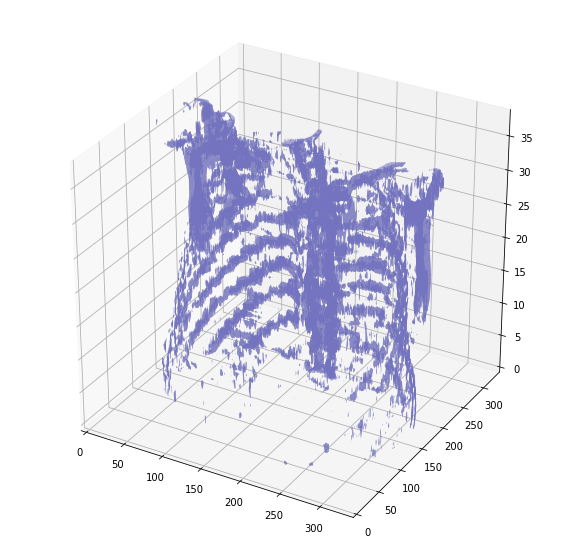

In [70]:
plot_3d(image1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  


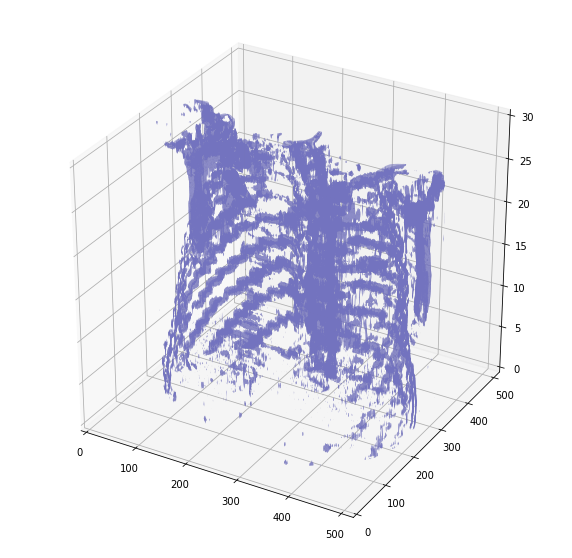

In [71]:
plot_3d(patient1_hu_scans)

## Segmentation
Segmentation is most important part of medical image processing as it extracts region of interest. CNN will perform better on segmented images rather than on whole chest image. Segmentation is done by many ways and most commonly by clustering. 

Clustering has several techniques such as K-means clustering, hierarchical clustering, divisive clustering, and mean shift clustering. Moreover, due to the irregular and fuzzy borders in most of the medical images, fuzzy set and neutrosophic set theories become important in the segmentation process to handle uncertainty in the medical images. Read more about medical image segmentation [here](https://www.sciencedirect.com/topics/engineering/medical-image-segmentation). After clustering, images are morphed using erosion(contraction) and dialation (expansion) to remove unwanted border areas and label different regions separately. So the steps goes as:

1.   Normalization of image.
2.   Clustering for separating lung from everything else.
3.   Threshold image.
4.   Morphology - Erosion followed by dialation.
5.   Label different regions and define regions with different colors.
6.   Create lung mask.
7.   Apply mask on original image and get final masked image.






In [75]:
def make_lungmask(img, display=False):
  '''This function performs segmentation on an image (image is given as argument).
  a second boolean argument (True or False) displays the image'''
  #Standardize the pixel values
  row_size= img.shape[0]
  col_size = img.shape[1]
  mean = np.mean(img)
  std = np.std(img)
  img = img-mean
  img = img/std
    
  # Find the average pixel value near the lungs
  # to renormalize washed out images
  middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
  mean = np.mean(middle)  
  max = np.max(img)
  min = np.min(img)
  # To improve threshold finding, I'm moving the 
  # underflow and overflow on the pixel spectrum
  img[img==max]=mean
  img[img==min]=mean
    
  # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
  #
  kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
  centers = sorted(kmeans.cluster_centers_.flatten())
  threshold = np.mean(centers)
    
  # Threshold the image and the output will be a binary image. Morphology workes either on binary or gray images.
  thresh_img = np.where(img<threshold,1.0,0.0)
    
  # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
  # We don't want to accidentally clip the lung.

  eroded = morphology.erosion(thresh_img,np.ones([3,3]))
  dilation = morphology.dilation(eroded,np.ones([8,8]))

  labels = measure.label(dilation) # Different labels are displayed in different colors
  label_vals = np.unique(labels)
  regions = measure.regionprops(labels)
  good_labels = []
  for prop in regions:
      B = prop.bbox
      if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
          good_labels.append(prop.label)
  mask = np.ndarray([row_size,col_size],dtype=np.int8)
  mask[:] = 0

  #  After just the lungs are left, we do another large dilation
  #  in order to fill in and out the lung mask 
  for N in good_labels:
    mask = mask + np.where(labels==N,1,0)
  mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

  if (display):
      fig, ax = plt.subplots(3, 2, figsize=[12, 12])
      ax[0, 0].set_title("Original")
      ax[0, 0].imshow(img, cmap='gray')
      ax[0, 0].axis('off')
      ax[0, 1].set_title("Threshold")
      ax[0, 1].imshow(thresh_img, cmap='gray')
      ax[0, 1].axis('off')
      ax[1, 0].set_title("After Erosion and Dilation")
      ax[1, 0].imshow(dilation, cmap='gray')
      ax[1, 0].axis('off')
      ax[1, 1].set_title("Color Labels")
      ax[1, 1].imshow(labels)
      ax[1, 1].axis('off')
      ax[2, 0].set_title("Final Mask")
      ax[2, 0].imshow(mask, cmap='gray')
      ax[2, 0].axis('off')
      ax[2, 1].set_title("Apply Mask on Original")
      ax[2, 1].imshow(mask*img, cmap='gray')
      ax[2, 1].axis('off')
        
      plt.show()
  return mask*img

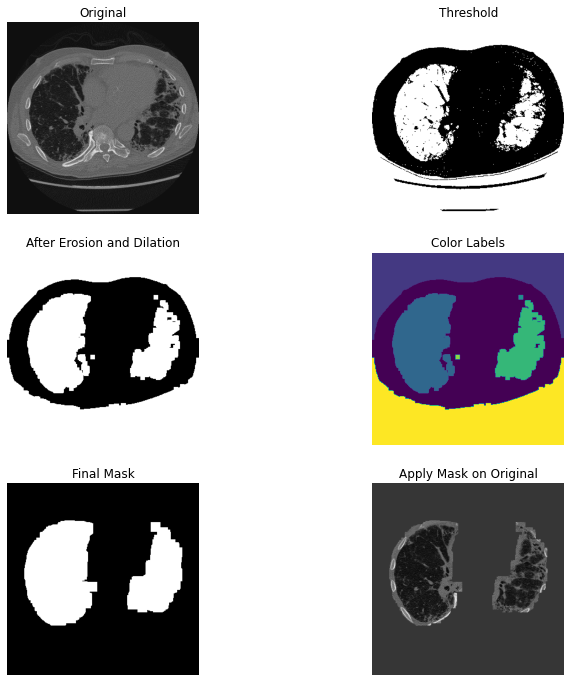

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [76]:
make_lungmask(image1[14], True)

In [78]:
def get_rows_cols(size):
  '''Returns the rows and columns of an image with a given sier (size is the argument)'''
  cols = 6
  rows = size // cols
  if (int(size%cols) != 0):
      rows = rows+1
  return rows,cols

In [80]:
def plot_stack(stack, start_with=10, show_every=3):
  '''Takes the stack length (1st argument) and returns a plot of stacks starting from (2nd argument) to the end and displays every n slie (3rd argument)'''
  size = (len(stack) - (start_with - 1))//show_every
  rows, cols = get_rows_cols(size)
  plt.tight_layout()
  fig,ax = plt.subplots(rows,cols,figsize=[12,12])
  for i in range(size-1):
      ind = start_with + i*show_every
      ax[int(i/cols),int(i % cols)].set_title('slice %d' % ind)
      ax[int(i/cols),int(i % cols)].imshow(stack[ind],cmap='gray')
      ax[int(i/cols),int(i % cols)].axis('off')
  plt.show()

<Figure size 432x288 with 0 Axes>

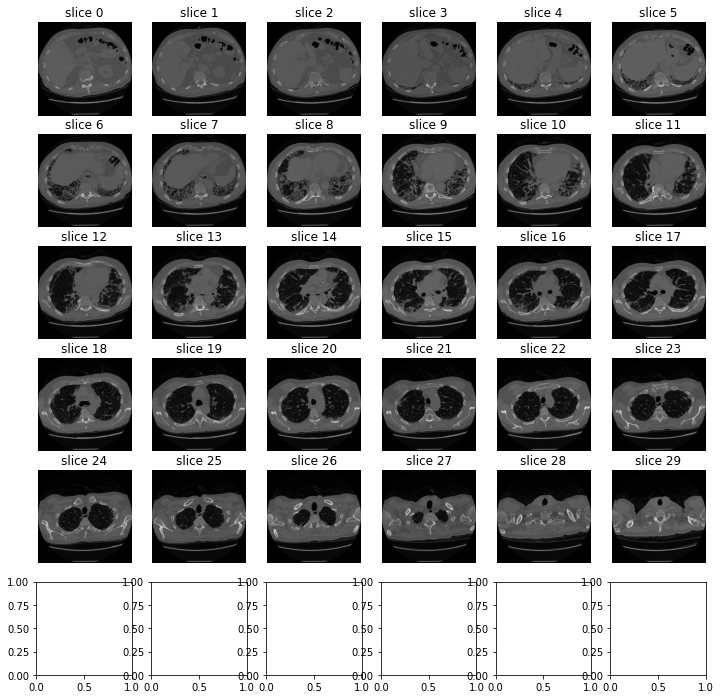

In [81]:
plot_stack(patient1_hu_scans, start_with=0, show_every=1)

<Figure size 432x288 with 0 Axes>

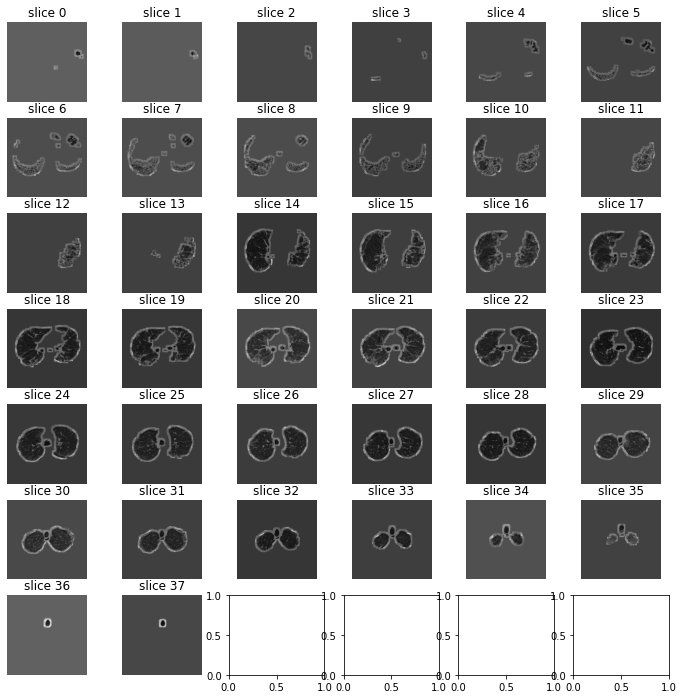

In [82]:
# TO DO: make ths a function where the user inputs and image to obtained masked stacks
masked_lung = []

for img in image1:
    masked_lung.append(make_lungmask(img))
    
plot_stack(masked_lung, start_with=0, show_every=1)

TO DO:
Code for running processing on the whole data all together. Outcome of the code will be .npz file for all patients. .npz files can be loaded using np.load() function for further use. 